## All imports

In [1]:
import pandas as pd
import pandoc
import pickle 
#import os
import re
from collections import Counter
from collections import defaultdict
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
#from sympy import symbols,Eq,solve
#from scipy.spatial.distance import euclidean
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
#import spacy
#nlp = spacy.load("en_core_web_sm")
from rouge_score import rouge_scorer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import pearsonr
import statsmodels.api as sm

[nltk_data] Downloading package punkt to
[nltk_data]     /home/sh.aubakirov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Dataset

In [2]:
def load_obj(name):  #for a sample dataset of 376 article texts
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def convert_string_to_list(string):  # for dataset of 17038 article texts
    try:
        return ast.literal_eval(string)
    except ValueError:
        # In case of error, return the original string
        return string

In [3]:
dataset = load_obj('ds_arx_mindf')
dataset.head()

,article_id,article_text,abstract_text,section_names,sections,len_text,len_abstract,opt_mindf,opt_mindf_r1,opt_maxdf,opt_maxdf_r1
4741,1312.4941,[the effect of the background rotation on the ...,[we report results on the geometrical statisti...,"[introduction, theoretical background on the g...",[[the effect of the background rotation on the...,285,11,0.008,0.547847,0.018,0.427984
4426,astro-ph0308422,[a standard picture of the crab nebula was giv...,[an axisymmetric model for the crab nebula is ...,"[introduction, a 3d model, reproduction of the...",[[a standard picture of the crab nebula was gi...,145,11,0.049,0.502655,0.607,0.386803
737,astro-ph9803257,"[the lyman alpha ( ly@xmath1 ) forest "" ( @xc...","[we present a systematic search for ovi(1032,1...","[introduction, modeling the lyman alpha forest...","[[the lyman alpha ( ly@xmath1 ) forest "" ( @x...",435,10,0.049,0.526432,0.046,0.408517
3132,1212.6057,[lithium is one of a few key chemical elements...,[lithium in the atmosphere of a f or g supergi...,"[introduction, comparison with theoretical pre...",[[lithium is one of a few key chemical element...,414,10,0.013,0.541311,0.102,0.517056
8435,1612.01735,[life science is regarded as the last forefron...,"[geometric , topological and graph theory mode...","[introduction, discrete apparatuses for biomol...",[[life science is regarded as the last forefro...,311,11,0.017,0.462061,0.071,0.386905


In [4]:
dataset['article_text']

4741     [the effect of the background rotation on the ...
4426     [a standard picture of the crab nebula was giv...
737      [the lyman alpha ( ly@xmath1 )  forest " ( @xc...
3132     [lithium is one of a few key chemical elements...
8435     [life science is regarded as the last forefron...
                               ...                        
2322     [soft deformable colloids , such as foam bubbl...
9415     [solar cycle 23 was predicted to reach a maxim...
14426    [this paper is the first step towards a mathem...
6459     [the description of complex interactions with ...
3662     [the current cosmological paradigm of a flat u...
Name: article_text, Length: 376, dtype: object

## Functions required

In [5]:
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    return text.lower()
    
#def split_into_sentences_for_abstract(text):
   # return re.split(r'[.!?\'\']', text)

def split_into_sentences(text):
    return sent_tokenize(text)

def distance_to_line(x0,y0,b,a):
    return np.abs(b*x0 - y0 + a)/(np.sqrt(b**2+1))

def compute_line_params(x_data, y_data):
    m = (y_data[-1] - y_data[0]) / (x_data[-1] - x_data[0])
    c = y_data[0] - m * x_data[0]
    return m, c

def exp_decreasing(x, a, b, c):
    return a * np.exp(-b * x) + c

## Keep the article texts and abstract texts separately 

In [6]:
article_texts = {}
abstract_texts= {}

for index, text in dataset['article_text'].items():
    paper_id = index
    article_texts[paper_id] = text

for index,text in dataset['abstract_text'].items():
    paper_id = index
    abstract_texts[paper_id] = text

keys = {key: [] for key in article_texts.keys()}
#keys

In [7]:
article_texts[4741]

['the effect of the background rotation on the dynamics of fluid flows is ubiquitous in large - scale geophysical and astrophysical flows , as well as in the context of industrial rotating machinery .',
 'it is well - known that the coriolis acceleration term in the navier ',
 'stokes equations is responsible for altering the flow dynamics including the anisotropisation of turbulent flows , but the underlying physical mechanisms are still poorly understood .',
 'another familiar phenomenon is that a three - dimensional ( 3d ) turbulent flow subject to a fast background rotation evolves towards a quasi - two - dimensional ( q2d ) state , which is characterised by a strong damping of velocity gradient components along the direction parallel to the rotation axis .',
 '+ the anisotropisation of turbulent flows induced by background rotation , has been the subject of several numerical and experimental investigations in the past , which led to important progress in the field .',
 'we briefly

#### The function processes a dictionary of article texts, combining text segments per article, splitting them into sentences, and cleaning the text to identify unique words. For each word, it tracks how often it appears across sentences and stores these sentences. The results are aggregated into two dictionaries, one detailing the frequency of each word per article and another mapping words to the sentences they appear in, both keyed by article index. "Dictionary in Dictionary"

In [8]:
def count_sentences_with_unique_words_per_article_fixed(article_texts):
    article_word_sentence_counts = {}
    article_word_sentence_sets = {}

    for index, text_list in article_texts.items():
        word_sentence_counts = defaultdict(int) 
        word_sentence_sets = defaultdict(set)
        combined_text = ' '.join(text_list)
        sentences = split_into_sentences(combined_text)

        for sentence in sentences:
            cleaned_sentence = clean_text(sentence)
            words = set(cleaned_sentence.split())
            for word in words:
                if word and word not in {',', '.'}:  
                    word_sentence_counts[word] += 1  
                    word_sentence_sets[word].add(cleaned_sentence)

        article_word_sentence_counts[index] = word_sentence_counts
        article_word_sentence_sets[index] = word_sentence_sets
    return article_word_sentence_counts,article_word_sentence_sets
dict_id_words_counts, dict_id_words_sentences = count_sentences_with_unique_words_per_article_fixed(dataset['article_text'])

### Here we tracked the number of sentences in each article text. At the first time we calculated them by ourselves, then we decided to take already found number of sentences from the dataset

In [9]:
number_of_sentences_per_article = {}

for article_id, word_sentence_sets in dict_id_words_sentences.items():
    all_sentences = set()
    for sentences in word_sentence_sets.values():
        all_sentences.update(sentences)
    number_of_sentences_per_article[article_id] = len(all_sentences)

number_of_sentences_article_texts_real = dataset['len_text'].to_numpy()
number_of_sentences_abstract_texts_real = dataset['len_abstract'].to_numpy()

for key,new_value in zip(number_of_sentences_per_article,number_of_sentences_article_texts_real):
    number_of_sentences_per_article[key] = new_value

#number_of_sentences_per_article

### Function that finds optimal min_df values for each document

In [10]:
min_df_values = {key: [] for key in keys.keys()}

def find_min_df(key,threshold):
    word_count_pairs = [(word, count) for word, count in dict_id_words_counts[key].items()] 
    filtered_word_count_pairs = [pair for pair in word_count_pairs if pair[1] >= threshold]

    sorted_pairs = sorted(filtered_word_count_pairs, key=lambda pair: pair[1], reverse=True)
    sorted_words = [pair[0] for pair in sorted_pairs]
    sorted_counts = [pair[1] for pair in sorted_pairs]
    
    words = np.arange(len(sorted_words))
    counts = np.array(sorted_counts)

    initial_params = [max(counts), 0.1, min(counts)]
    params, _ = curve_fit(exp_decreasing, words, counts, p0=initial_params)
    exp_values = [exp_decreasing(x,*params) for x in words]
    m, c = compute_line_params(words, exp_values)
    distances_from_exp = [distance_to_line(x, exp_decreasing(x, *params), m, c) for x in words]

    intersection_points = []
    
    for i in range(1,len(exp_values)):
        if (exp_values[i-1]-distances_from_exp[i-1]) * (exp_values[i]-distances_from_exp[i]) < 0:
            intersection_points.append(i)

    try:
        min_df = exp_values[intersection_points[1]]/number_of_sentences_per_article[key]
    except:
        min_df = -1
   
    return min_df

### Function that generates summaries for each article text

In [11]:
def greed_sum(text, num_sent, min_df, max_df=1.0):
    try:
        # Fit a TFIDF vectorizer
        vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df)
        vectorizer.fit(text)

        # Get the matrix
        X = vectorizer.transform(text).toarray()

        # Get the sentence indices
        idx = []
        while sum(sum(X)) != 0:
            ind = np.argmax(X.sum(axis=1))
            idx.append(ind)

            # Update the matrix by deleting the columns corresponding to the words found in the previous step
            cols = X[ind]
            col_idx = [i for i in range(len(cols)) if cols[i] > 0]
            X = np.delete(X, col_idx, 1)

        idx = idx[:num_sent]
        idx.sort()

        summary = [text[i] for i in idx]
        return summary
    except ValueError as e:
        return ["Error: " + str(e)]

### Function that compares the generated summary with etalon text

In [12]:
def compute_rouge_score(generated_text, etalon_text):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    generated_text = ' '.join(generated_text)  
    etalon_text = ' '.join(etalon_text)  
    scores = scorer.score(generated_text, etalon_text)
    rouge1_fmeasure = scores['rouge1'].fmeasure  #
    return rouge1_fmeasure

### The main part of the code. Here we used optimization to find optimal min_df values with all created functions. For each document there is optimal minimum word frequency (threshold), which in turn leads to optimal min_df value such that the highest possible ROUGE score for that document is obtained.

In [13]:
optimal_thresholds = {}
rouge1_fmeasure_scores = {}
summary_texts = {}
min_df_values_dict = {}
for document_id in article_texts.keys():
    best_rouge_score = 0
    optimal_threshold = None
    optimal_generated_text = None
    optimal_min_df = None

    for threshold in range(0, 20):  
        min_df = find_min_df(document_id, threshold)
        generated_text = greed_sum(article_texts[document_id], number_of_sentences_per_article[document_id],min_df) 
        reference_text = abstract_texts[document_id]  
        
        current_rouge_score = compute_rouge_score(generated_text, reference_text)
        if current_rouge_score > best_rouge_score:
            best_rouge_score = current_rouge_score
            optimal_threshold = threshold
            optimal_generated_text = generated_text
            optimal_min_df = min_df
    rouge1_fmeasure_scores[document_id] = best_rouge_score
    min_df_values_dict[document_id] = optimal_min_df
    summary_texts[document_id] = optimal_generated_text
    
    optimal_thresholds[document_id] = optimal_threshold
    print(f"Optimal threshold for document {document_id}: {optimal_threshold}")

Optimal threshold for document 4741: 7
Optimal threshold for document 4426: 5
Optimal threshold for document 737: 12
Optimal threshold for document 3132: 4
Optimal threshold for document 8435: 4
Optimal threshold for document 1376: 19
Optimal threshold for document 1867: 7
Optimal threshold for document 11147: 11
Optimal threshold for document 11425: 6
Optimal threshold for document 13797: 6
Optimal threshold for document 15736: 12
Optimal threshold for document 2869: 4
Optimal threshold for document 8296: 5
Optimal threshold for document 8873: 5
Optimal threshold for document 6000: 5
Optimal threshold for document 4181: 8
Optimal threshold for document 5792: 6
Optimal threshold for document 11321: 6
Optimal threshold for document 9587: 4
Optimal threshold for document 15508: 15
Optimal threshold for document 13610: 9
Optimal threshold for document 9776: 9
Optimal threshold for document 6214: 5
Optimal threshold for document 7549: 7
Optimal threshold for document 12781: 7
Optimal thres

### Example of calculating the ROUGE score for document 4741

In [14]:
summary_texts[4741]

['thanks to 3d - ptv , we have access to the vorticity vector , and studied its dynamics in rotating turbulence . for the non - rotating case , this kind of particle tracking studies has been pursued several years ago  @xcite , and rotating ptv experiments quantified the transition from 3d to q2d large - scale dynamics  @xcite . but laboratory experiments aimed at exploring the influence of system rotation on the dynamics of the small scales and in particular of the vorticity vector have not yet been reported and are the main topics of the present paper . in the context of the existing literature , the latter studies on the lagrangian statistics of velocities and accelerations of passive tracers , and the present work reported here on the geometrical statistics of the vorticity and the strain rate tensor in rotating turbulence are based on experiments resembling the ones performed in closed non - shallow containers , and with continuous forcing applied locally in space ( see , e.g. , r

In [15]:
abstract_texts[4741]

['we report results on the geometrical statistics of the vorticity vector obtained from experiments in electromagnetically forced rotating turbulence .',
 'a range of rotation rates @xmath0 is considered , from non - rotating to rapidly rotating turbulence with a maximum background rotation rate of @xmath1 rad / s ( with rossby number much smaller than unity ) . typically , the taylor - scale reynolds number in our experiments is around @xmath2 .',
 'the measurement volume is located in the centre of the fluid container above the bottom boundary layer , where the turbulent flow can be considered locally statistically isotropic and horizontally homogeneous for the non - rotating case , see van bokhoven _ et al .',
 '_ , _ phys .',
 'fluids _ * 21 * , 096601 ( 2009 ) . based on the full set of velocity derivatives , measured in a lagrangian way by 3d particle tracking velocimetry',
 ', we have been able to quantify statistically the effect of system rotation on several flow properties . 

In [16]:
compute_rouge_score(summary_texts[4741],abstract_texts[4741])

0.504983388704319

In [17]:
rouge1_fmeasure_scores.values()
rouge1_fmeasure_scores = list(rouge1_fmeasure_scores.values())
mean_rouge1_fmeasure =np.mean(rouge1_fmeasure_scores)
print(mean_rouge1_fmeasure)

0.49180070129096204


In [18]:
#min_word_count = np.min(list(dict_id_words_counts.values().values()))
# Assuming dict_id_words_counts is your nested dictionary where each key maps to another dictionary
# Example structure: dict_id_words_counts = {'doc1': {'word1': 4, 'word2': 5}, 'doc2': {'word3': 3, 'word4': 2}}
# Extract all word counts from each inner dictionary
#word_counts = [count for inner_dict in dict_id_words_counts.values() for count in inner_dict.values()]
#min_word_count = np.max(word_counts)
#print(min_word_count)

***Here is the optimal thresholds stats for the Results part of the paper***

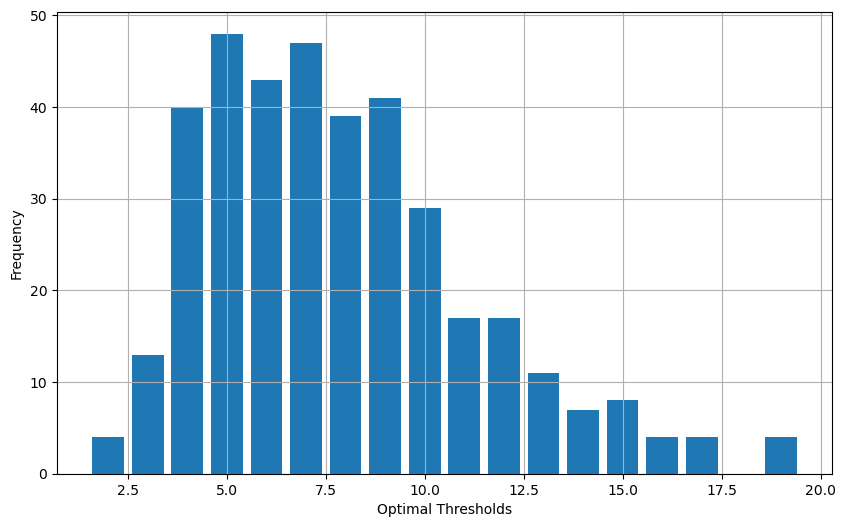

In [19]:
optimal_thresholds_list = list(optimal_thresholds.values())
max_value = max(optimal_thresholds_list)
min_value = min(optimal_thresholds_list)
bins = range(min_value, max_value + 2)  # +2 ensures the last bin includes the max value
plt.figure(figsize=(10, 6))
plt.hist(optimal_thresholds_list, bins=bins, align='left', rwidth=0.8)  # align='left' centers the bars over the integers
plt.xlabel('Optimal Thresholds')
plt.ylabel('Frequency')
#plt.title('Histogram ')
plt.grid(True)  # Optional: Adds a grid for easier reading
plt.show()

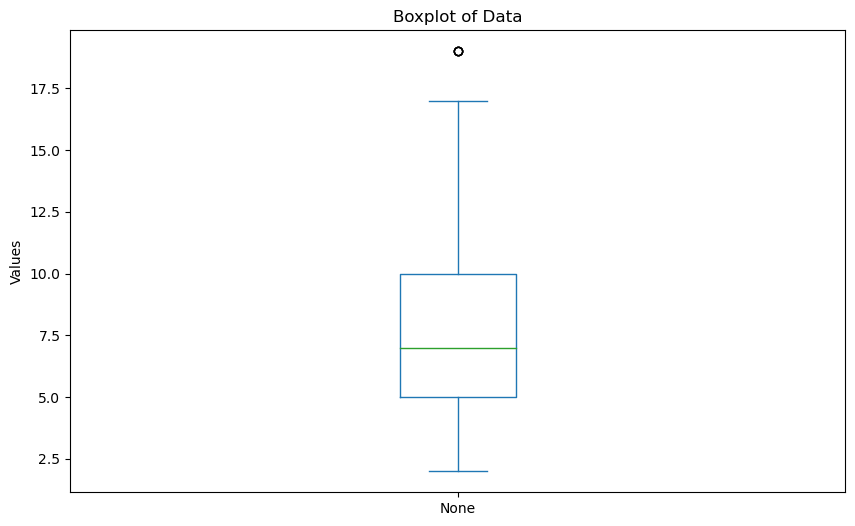

In [20]:
data_series = pd.Series(optimal_thresholds_list)

# Create and display the boxplot
plt.figure(figsize=(10, 6))
data_series.plot(kind='box')
plt.title('Boxplot of Data')
plt.ylabel('Values')
plt.show()

***Describing relationship between ROUGE scores and min_df values***

Correlation Coefficient: -0.08796249394935961


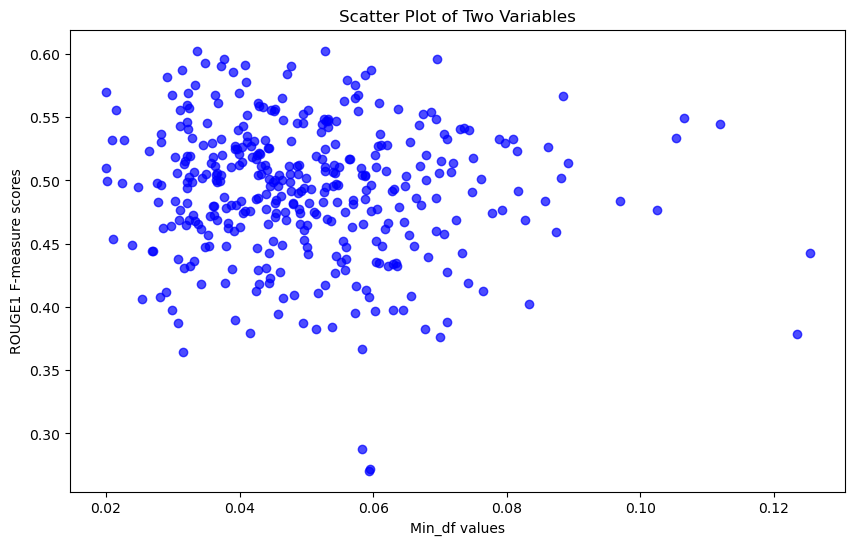

In [25]:
min_df_values = []
for value in min_df_values_dict.values():
    min_df_values.append(value)

correlation_coefficient = np.corrcoef(rouge1_fmeasure_scores, min_df_values)[0, 1]
print("Correlation Coefficient:", correlation_coefficient)

plt.figure(figsize=(10, 6))
plt.scatter(min_df_values, rouge1_fmeasure_scores, color='blue', alpha=0.7)
plt.title('Scatter Plot of Two Variables')
plt.xlabel('Min_df values')
plt.ylabel('ROUGE1 F-measure scores')
plt.show()

**Distribution of ROUGE scores**

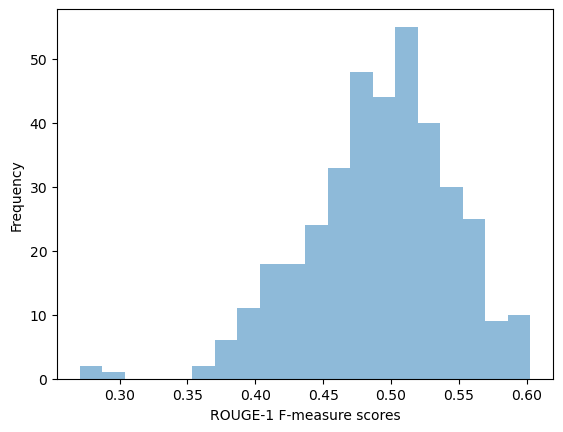

0.49180070129096204


In [26]:
plt.hist(rouge1_fmeasure_scores, bins=20, alpha=0.5)
plt.xlabel('ROUGE-1 F-measure scores')
plt.ylabel('Frequency')
plt.show()
print(np.mean(rouge1_fmeasure_scores))